<a href="https://colab.research.google.com/github/ewclark47/ADL-Project/blob/main/seq2seq_nmt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
!pip install "tensorflow-text>=2.11"
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

### Load data

In [ ]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

"# Download the file\nimport pathlib\n\npath_to_zip = tf.keras.utils.get_file(\n    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',\n    extract=True)\n\npath_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'\n"

In [ ]:
def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  context = np.array([context for context, target in pairs])
  target = np.array([target for context, target in pairs])

  return target, context

"def load_data(path):\n  text = path.read_text(encoding='utf-8')\n\n  lines = text.splitlines()\n  pairs = [line.split('\t') for line in lines]\n\n  context = np.array([context for target, context in pairs])\n  target = np.array([target for target, context in pairs])\n\n  return target, context"

In [ ]:
target_raw, context_raw = load_data(path_to_file)
print(context_raw[-1])

'target_raw, context_raw = load_data(path_to_file)\nprint(context_raw[-1])'

In [ ]:
print(target_raw[-1])

'print(target_raw[-1])'

### Create a tf.data dataset

From these arrays of strings you can create a `tf.data.Dataset` of strings that shuffles and batches them efficiently:

In [ ]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
rest_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))'''

'BUFFER_SIZE = len(context_raw)\nBATCH_SIZE = 64\n\nis_train = np.random.uniform(size=(len(target_raw),)) < 0.8\n\ntrain_raw = (\n    tf.data.Dataset\n    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))\n    .shuffle(BUFFER_SIZE)\n    .batch(BATCH_SIZE))\nrest_raw = (\n    tf.data.Dataset\n    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))\n    .shuffle(BUFFER_SIZE)\n    .batch(BATCH_SIZE))'

In [ ]:
val_raw = rest_raw.take(3*round(len(rest_raw)/4))
test_raw = rest_raw.skip(round(len(rest_raw)/4))

'val_raw = rest_raw.take(3*round(len(rest_raw)/4))\ntest_raw = rest_raw.skip(round(len(rest_raw)/4))'

In [ ]:
train_raw.save('/content/gdrive/My Drive/Colab Notebooks/ADL_tokenizer_es_en_translator/small_train_data')
val_raw.save('/content/gdrive/My Drive/Colab Notebooks/ADL_tokenizer_es_en_translator/small_val_data')
test_raw.save('/content/gdrive/My Drive/Colab Notebooks/ADL_tokenizer_es_en_translator/small_test_data')

"train_raw.save('/content/gdrive/My Drive/Colab Notebooks/ADL_tokenizer_es_en_translator/small_train_data')\nval_raw.save('/content/gdrive/My Drive/Colab Notebooks/ADL_tokenizer_es_en_translator/small_val_data')\ntest_raw.save('/content/gdrive/My Drive/Colab Notebooks/ADL_tokenizer_es_en_translator/small_test_data')"

### Load Dataset

In [ ]:
train_raw = tf.data.Dataset.load('/content/gdrive/My Drive/Colab Notebooks/ADL_tokenizer_es_en_translator/small_train_data')
val_raw = tf.data.Dataset.load('/content/gdrive/My Drive/Colab Notebooks/ADL_tokenizer_es_en_translator/small_val_data')
test_raw = tf.data.Dataset.load('/content/gdrive/My Drive/Colab Notebooks/ADL_tokenizer_es_en_translator/small_test_data')

In [ ]:
for example_target_strings, example_context_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'He asked me if I knew her telephone number.'
 b'Tom came to my house yesterday.'
 b'She was too proud to ask him for help.' b'I study Korean.'
 b'He got hurt in the game yesterday.'], shape=(5,), dtype=string)

tf.Tensor(
[b'Me pregunt\xc3\xb3 si yo sab\xc3\xada el n\xc3\xbamero de tel\xc3\xa9fono de ella.'
 b'Tom vino a mi casa ayer.'
 b'Ella era demasiado orgullosa para pedir su ayuda.'
 b'Yo estudio coreano.'
 b'\xc3\x89l se hiri\xc3\xb3 en el partido de ayer.'], shape=(5,), dtype=string)


### Text preprocessing

In [ ]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

#### Text Vectorization

In [ ]:
max_vocab_size = 15000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [ ]:
context_text_processor.adapt(train_raw.map(lambda target, context: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

In [ ]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda target, context: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

In [ ]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 13, 172, 22, 71, 6, 287, 47, 710, 499, 4, 3],
 [2, 9, 200, 7, 24, 127, 181, 4, 3],
 [2, 26, 18, 102, 718, 7, 213, 44, 25, 92, 4, 3]]>

In [ ]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] he asked me if i knew her telephone number . [END]'

Text(0.5, 1.0, 'Mask')

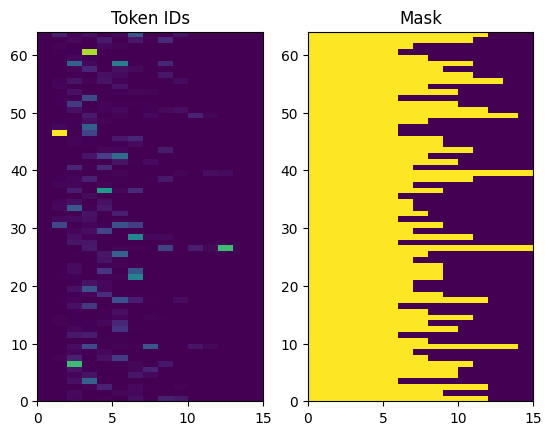

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

### Process the dataset



In [ ]:
def process_text(target, context):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)
test_ds = test_raw.map(process_text, tf.data.AUTOTUNE)

Here is the first sequence of each, from the first batch:

In [ ]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy()) 

[  2  13 172  22  71   6 287  47 710 499]

[  2  18 240  44  39 171   7 456   6 282]
[ 18 240  44  39 171   7 456   6 282   6]


In [ ]:
UNITS = 512

### Encoder

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

Test it:

In [ ]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 15)
Encoder output, shape (batch, s, units): (64, 15, 512)


### Attention Mechanism

In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()
 
    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)
    
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    
    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 15, 512)
Target sequence, shape (batch, t, units): (64, 16, 512)
Attention result, shape (batch, t, units): (64, 16, 512)
Attention weights, shape (batch, t, s):    (64, 16, 15)


In [ ]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([0.99999994, 1.        , 1.        , 1.        , 0.99999994,
       0.9999999 , 0.99999994, 0.99999994, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ], dtype=float32)

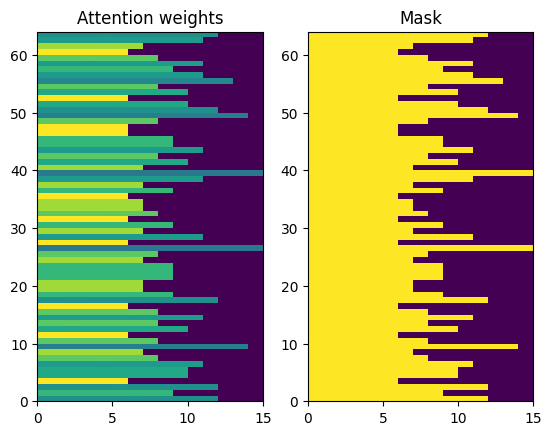

In [ ]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


### Decoder

In [ ]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

### Training

In [ ]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [ ]:
decoder = Decoder(target_text_processor, UNITS)

In [ ]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 15, 512)
input target tokens shape: (batch, t) (64, 16)
logits shape shape: (batch, target_vocabulary_size) (64, 16, 15000)


#### Inference

To use it for inference you'll need a couple more methods:

In [ ]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [ ]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [ ]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state

In [ ]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'varia carrera sacan buscando valores precio propietario tatuaje leelo empieces',
       b'cervezas averiguemoslo aritmetica pregunta sellado cojan pican algun condenaron ponerme',
       b'atreves comparte peaton cerezo quebrados parto obstinada gasto racionalmente occidental'],
      dtype=object)

Since the model's untrained, it outputs items from the vocabulary almost uniformly at random.

### Create the Translator

In [ ]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [ ]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 15)
Target tokens, shape: (batch, t) (64, 16)
logits, shape: (batch, t, target_vocabulary_size) (64, 16, 15000)


### Train

In [ ]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [ ]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [ ]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 9.615806, 'expected_acc': 6.666666666666667e-05}

In [ ]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 9s 84ms/step - loss: 9.6189 - masked_acc: 0.0000e+00 - masked_loss: 9.6189


{'loss': 9.618927955627441,
 'masked_acc': 0.0,
 'masked_loss': 9.618927955627441}

In [ ]:
model.summary()

Model: "translator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  9495040   
                                                                 
 decoder_1 (Decoder)         multiple                  18002584  
                                                                 
Total params: 27,497,624
Trainable params: 27,497,624
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
100/100 [==============================] - 45s 287ms/step - loss: 5.2496 - masked_acc: 0.2806 - masked_loss: 5.2496 - val_loss: 4.2857 - val_masked_acc: 0.3656 - val_masked_loss: 4.2857
Epoch 2/100
100/100 [==============================] - 12s 120ms/step - loss: 3.8950 - masked_acc: 0.4121 - masked_loss: 3.8950 - val_loss: 3.4994 - val_masked_acc: 0.4529 - val_masked_loss: 3.4994
Epoch 3/100
100/100 [==============================] - 9s 90ms/step - loss: 3.2639 - masked_acc: 0.4872 - masked_loss: 3.2639 - val_loss: 2.9169 - val_masked_acc: 0.5270 - val_masked_loss: 2.9169
Epoch 4/100
100/100 [==============================] - 10s 100ms/step - loss: 2.7931 - masked_acc: 0.5498 - masked_loss: 2.7931 - val_loss: 2.5689 - val_masked_acc: 0.5709 - val_masked_loss: 2.5689
Epoch 5/100
100/100 [==============================] - 11s 107ms/step - loss: 2.5172 - masked_acc: 0.5867 - masked_loss: 2.5172 - val_loss: 2.3202 - val_masked_acc: 0.6065 - val_masked_loss: 2.3202
Epoch 6/100


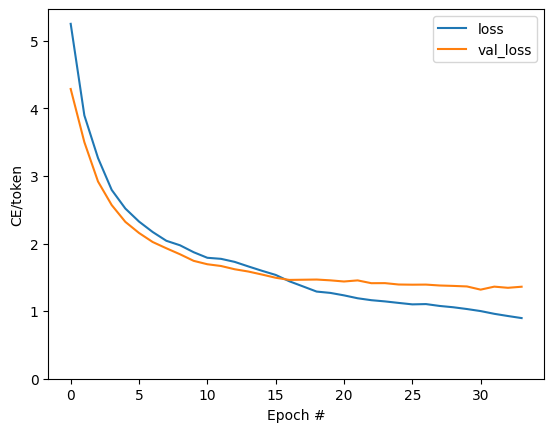

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

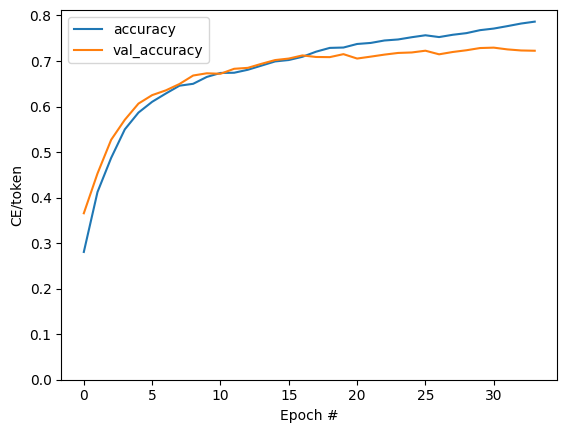

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

### Add additional Translator functionality

In [ ]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)
        
    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)
    
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [ ]:
result = model.translate(['Are you still at home?']) # ¿Todavía está en casa?
result[0].numpy().decode()

'¿ estais todavia en casa ? '

In [ ]:
result = model.translate(['Hello']) 
result[0].numpy().decode()

'[UNK] de nuevo . '

In [ ]:
result = model.translate(['My name is Tim']) 
result[0].numpy().decode()

'mi nombre es [UNK] . '

Use that to generate the attention plot:

In [ ]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

<ipython-input-46-93059eaa9bfc>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-46-93059eaa9bfc>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


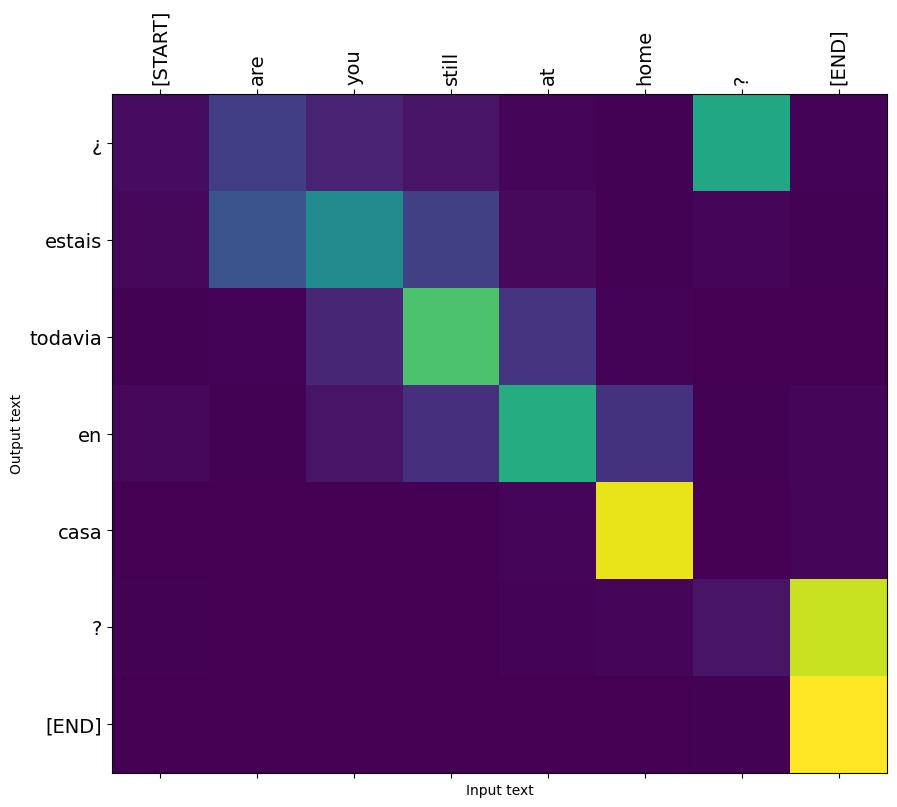

In [ ]:
model.plot_attention('Are you still at home?') # ¿Todavía está en casa?

Translate a few more sentences and plot them:

<ipython-input-46-93059eaa9bfc>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-46-93059eaa9bfc>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


CPU times: user 330 ms, sys: 7.14 ms, total: 337 ms
Wall time: 332 ms


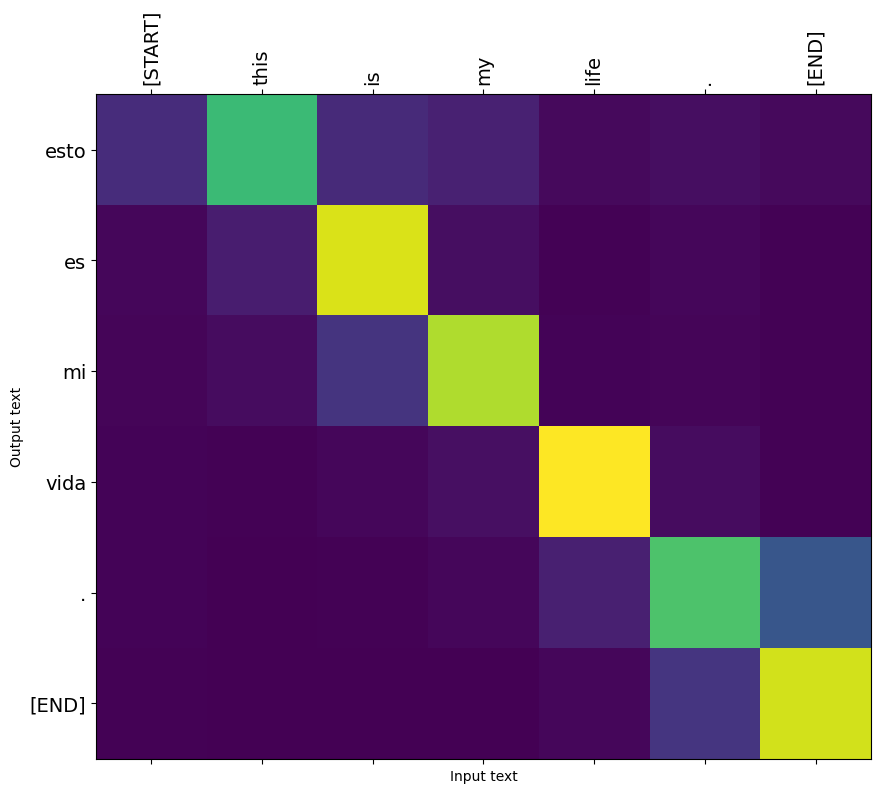

In [ ]:
%%time
model.plot_attention('This is my life.') # Esta es mi vida

<ipython-input-46-93059eaa9bfc>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
<ipython-input-46-93059eaa9bfc>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


CPU times: user 307 ms, sys: 5.55 ms, total: 312 ms
Wall time: 309 ms


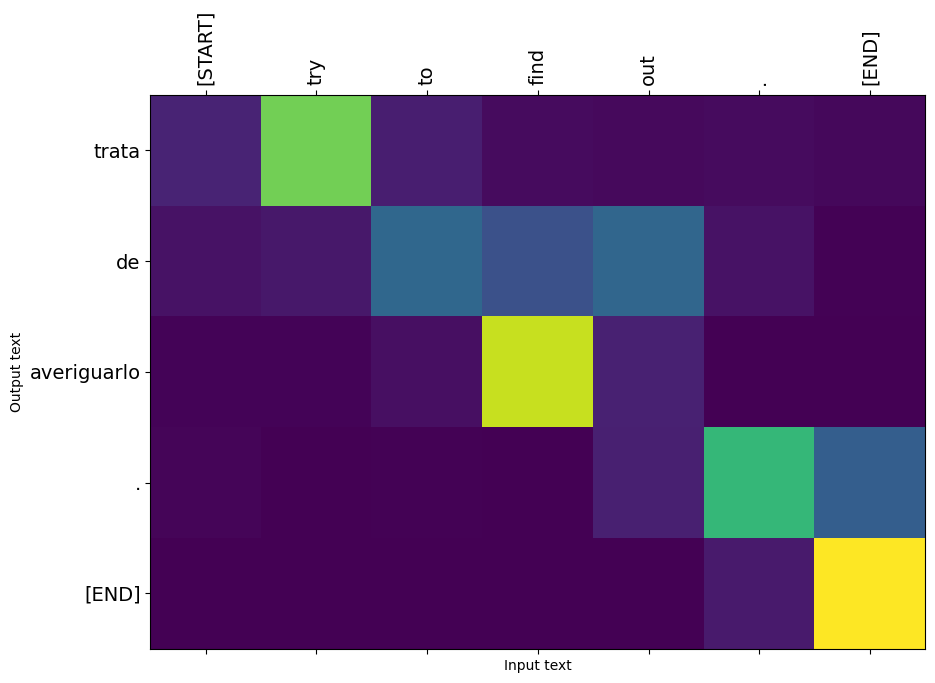

In [ ]:
%%time
model.plot_attention('Try to find out.') # Tratar de descubrir

### BLEU Scores

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
for es, en in test_raw.take(1):
  print(len(en))
  print(en.numpy()[0].decode())

64
It is difficult for him to solve the problem.


In [ ]:
@Translator.add_method
def test_bleu_score(self, test_set):
  bleu_scores = []
  for context_sent, target_sent in test_set:
    for i in range(len(context_sent)):
      output = self.translate([context_sent.numpy()[i].decode()])
      output = output[0].numpy().decode()

      output = tf_lower_and_split_punct(output)
      output = output.numpy().decode().split()[1:-1]
      #print('output is: ', output)

      reference = tf_lower_and_split_punct(target_sent.numpy()[i].decode()).numpy().decode().split()[1:-1]
      #print('reference is: ', reference)

      bleu_scores.append(sentence_bleu(reference, output))
  
  avg_bleu = sum(bleu_scores)/len(bleu_scores)

  return avg_bleu

In [ ]:
@Translator.add_method
def test_bleu_score_unigram(self, test_set):
  bleu_scores = []
  for context_sent, target_sent in test_set:
    for i in range(len(context_sent)):
      output = self.translate([context_sent.numpy()[i].decode()])
      output = output[0].numpy().decode()

      output = tf_lower_and_split_punct(output)
      output = output.numpy().decode().split()[1:-1]
      #print('output is: ', output)

      reference = tf_lower_and_split_punct(target_sent.numpy()[i].decode()).numpy().decode().split()[1:-1]
      #print('reference is: ', reference)

      bleu_scores.append(sentence_bleu(reference, output, weights=(1,0,0,0)))
  
  avg_bleu = sum(bleu_scores)/len(bleu_scores)

  return avg_bleu

In [ ]:
print('BLEU Score for seq2seq is: ', model.test_bleu_score_unigram(test_raw.skip(150)))

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

BLEU Score for seq2seq is:  0.21802377593791358
